In [2]:
# !pip install faiss-cpu
# !pip install sentence-transformers
# !pip install tiktoken
# !pip install langchain
# !pip install -U langchain-openai
# !pip install -U langchain-community
# !pip install openpyxl
# !pip install datasets faiss-cpu

In [20]:
import os
import pandas as pd
import requests
from dotenv import load_dotenv

# LangChain 関連
from langchain.chains import RetrievalQA
from langchain.chat_models import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.schema import Document

# GraphRAG用
from transformers import RagTokenizer, RagRetriever, RagSequenceForGeneration
import networkx as nx
from datasets import Dataset
from langchain.schema import HumanMessage
import faiss
import json
from itertools import combinations
import matplotlib.pyplot as plt


In [4]:
# .env ファイルを読み込む
load_dotenv()

True

In [5]:
# 1. データの読み込み
df = pd.read_excel("100データ5.xlsx", engine="openpyxl")
df.head()

,id,date,timestamp,place,latitude,longitude,lat_long,diary_text
0,1,18278,1950-01-15T10:30:00Z,大阪市住吉区,34.5938,135.4937,"34.5938° N, 135.4937°",父の数学の参考書を読みながら、将来の夢について考えた。野球への情熱が日に日に強くなっていく。...
1,2,18709,1951-03-22T15:45:00Z,大阪市住吉区,34.5938,135.4937,"34.5938° N, 135.4937°",今日の野球の練習は厳しかったが、チームメイトと共に汗を流すことで絆が深まった。夕方は家族と一...
2,3,19124,1952-05-10T09:15:00Z,大阪市住吉区,34.5938,135.4937,"34.5938° N, 135.4937°",今朝、父と一緒に野球の戦術について語り合った。数学的思考が野球にも活かせると感じた。夕方は近...
3,4,19565,1953-07-25T16:20:00Z,大阪市住吉区,34.5938,135.4937,"34.5938° N, 135.4937°",夏の甲子園予選に向けて、猛暑の中で練習に励んでいる。汗と熱意で、チームの勝利を信じている。夜...
4,5,19972,1954-09-05T14:40:00Z,大阪市住吉区,34.5938,135.4937,"34.5938° N, 135.4937°",高校野球の最後の大会。悔いなく全力で戦った。負けは悔しいが、チームメイトとの絆は一生の宝物と...


In [6]:
API_KEY = os.getenv("GOOGLE_MAPS_API_KEY")  # 直接記述する場合は "your-api-key" に変更

# 緯度・経度から住所を取得し、国内・海外で異なるフォーマットに整形
def get_formatted_location(latitude, longitude):
    url = f"https://maps.googleapis.com/maps/api/geocode/json?latlng={latitude},{longitude}&key={API_KEY}&language=ja"
    response = requests.get(url)
    data = response.json()
    
    if "results" in data and len(data["results"]) > 0:
        address_components = data["results"][0]["address_components"]
        
        country = ""
        prefecture = ""
        city = ""

        for component in address_components:
            if "country" in component["types"]:
                country = component["long_name"]  # 日本 or France
            elif "administrative_area_level_1" in component["types"]:
                prefecture = component["long_name"]  # 東京都, 大阪府
            elif "locality" in component["types"] or "administrative_area_level_2" in component["types"]:
                city = component["long_name"]  # 新宿区, 横浜市

        # 国内なら「東京都 新宿区」、海外なら「フランス Paris」に変換
        if country == "日本":
            return f"{prefecture} {city}".replace("都", "").replace("府", "").replace("県", "")  # 「東京都 新宿区」→「東京 新宿」
        else:
            return f"{country} {city}"

    return "住所情報が取得できませんでした"

# Excelファイルの読み込み
df = pd.read_excel("100データ5.xlsx", engine="openpyxl")

# location_name列を追加（緯度・経度を使って変換）
df["location"] = df.apply(lambda row: get_formatted_location(row["latitude"], row["longitude"]), axis=1)

In [7]:
documents = []
for idx, row in df.iterrows():
    text_content = f"""日記ID: {row['id']}
日時: {row['timestamp']}
場所: {row['location']}
本文: {row['diary_text']}
画像: {row.get('image_path', '画像パスなし')}"""

    documents.append(Document(
        page_content=text_content,
        metadata={"id": row["id"]}
    ))

In [8]:
documents

[Document(metadata={'id': 1}, page_content='日記ID: 1\n日時: 1950-01-15T10:30:00Z\n場所: 大阪 堺市\n本文: 父の数学の参考書を読みながら、将来の夢について考えた。野球への情熱が日に日に強くなっていく。レフトの守備練習に励み、甲子園を目指す決意を新たにした。\n画像: 画像パスなし'),
 Document(metadata={'id': 2}, page_content='日記ID: 2\n日時: 1951-03-22T15:45:00Z\n場所: 大阪 堺市\n本文: 今日の野球の練習は厳しかったが、チームメイトと共に汗を流すことで絆が深まった。夕方は家族と一緒に夕食を楽しんだ。将来への希望に胸を膨らませている。\n画像: 画像パスなし'),
 Document(metadata={'id': 3}, page_content='日記ID: 3\n日時: 1952-05-10T09:15:00Z\n場所: 大阪 堺市\n本文: 今朝、父と一緒に野球の戦術について語り合った。数学的思考が野球にも活かせると感じた。夕方は近所の友人とキャッチボールを楽しんだ。\n画像: 画像パスなし'),
 Document(metadata={'id': 4}, page_content='日記ID: 4\n日時: 1953-07-25T16:20:00Z\n場所: 大阪 堺市\n本文: 夏の甲子園予選に向けて、猛暑の中で練習に励んでいる。汗と熱意で、チームの勝利を信じている。夜は冷たい麦茶で喉を潤した。\n画像: 画像パスなし'),
 Document(metadata={'id': 5}, page_content='日記ID: 5\n日時: 1954-09-05T14:40:00Z\n場所: 大阪 堺市\n本文: 高校野球の最後の大会。悔いなく全力で戦った。負けは悔しいが、チームメイトとの絆は一生の宝物となった。夕方、父から励ましの言葉をもらった。\n画像: 画像パスなし'),
 Document(metadata={'id': 6}, page_content='日記ID: 6\n日時: 1955-12-18T11:55:00Z\n場所: 大阪 堺市\n本文: 大学受験勉強に没頭している。野球への

In [9]:
# 2. 埋め込みモデルを設定
# --- (b) Azure OpenAI Embeddingsを使う場合 ---
embedding_model = AzureOpenAIEmbeddings(
    deployment="text-embedding-3-large",  # ✅ ← 正しくは deployment=
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2023-05-15",
    chunk_size=1
)

In [10]:
# --- (b) Azure OpenAI Embeddingsを使う場合 ---

# FAISSベクトルストアを構築
#  - from_documents() で一度にDocumentリストをEmbeddingし、インデックスを構築
faiss_db = FAISS.from_documents(documents, embedding_model)

# =====================================
# 3) RetrievalQA チェーン構築
# =====================================
# Azure OpenAI を LangChain の llm として定義
chat_llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"), 
    openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    deployment_name="gpt-4o-mini",  # Azure でデプロイしたモデル名
    temperature=0.7
)

# RetrievalQAを作成
retrieval_qa = RetrievalQA.from_chain_type(
    llm=chat_llm,
    chain_type="stuff",  # 単純に検索結果ドキュメントを結合する方式
    retriever=faiss_db.as_retriever(search_kwargs={"k": 3})
)

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_18764\4052380232.py:11: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  chat_llm = AzureChatOpenAI(


In [11]:
# 家族構成の定義
calling_name1="僕"
calling_name2="タラちゃん"
calling_name3="ママ"
relation_name1="本人"
relation_name2="息子"
relation_name3="妻"
birthday_name1="1940-07-21"
birthday_name2="1970-05-24"
birthday_name3="1970-10-18"

In [12]:
# --- (b) Azure OpenAI Embeddingsを使う場合 ---

# =====================================
# 4) デモ用の質問 + 類似スコア付き検索
# =====================================
question = "誕生日の思い出は？"

# スコア付きで検索（類似度が高いほどスコアは小さい）
retriever = faiss_db.as_retriever(search_kwargs={"k": 3})
docs_and_scores = retriever.vectorstore.similarity_search_with_score(question, k=3)

In [13]:
# 検索結果の表示
print("▼ 検索でヒットした日記とスコア（スコアが小さいほど類似）:")
for i, (doc, score) in enumerate(docs_and_scores):
    print(f"\n--- Top {i+1} ---")
    print(f"スコア: {score:.4f}")
    print(doc.page_content)  # 長いので最初だけ表示

# ヒットしたドキュメントを連結して、プロンプトとして LLM に渡す
context = "\n---\n".join([doc.page_content for doc, _ in docs_and_scores])

# 親として振る舞うよう明示したプロンプト
final_prompt = PromptTemplate.from_template(
    """
    あなたは天国にいて子供を見守っています。
    あなたに語りかけるあなたの子供のコメント{question}に対して、
    家族の素晴らしい思い出を一緒に回想してコメントを作成してください。
    全てのコメントは親子間のフランクな口調で、優しく語りかけるような表現にしてください。
    あなたが残した日記のコメントは下記3件あります。{context}
    日記の内容を含めて回想してください。
    ただし、子供のコメントに対して、ロケーション・場所・年月日が大きく異なる日記の内容は回想に含める必要はありません。
    なお、あなたの家族構成と呼称を伝えます。{relation_name1}のことを{calling_name1}、
    {relation_name2}のことを{calling_name2}、{relation_name3}のことを{calling_name3}と呼んでください。
    あなたの家族の誕生日は、{relation_name1}は{birthday_name1}、{relation_name2}は{birthday_name2}、
    {relation_name3}は{birthday_name3}となります。こちらも文脈に合えば使ってください。
    200文字以内にしてください。
    """
).partial(
    calling_name1=calling_name1,
    calling_name2=calling_name2,
    calling_name3=calling_name3,
    relation_name1=relation_name1,
    relation_name2=relation_name2,
    relation_name3=relation_name3,
    birthday_name1=birthday_name1,
    birthday_name2=birthday_name2,
    birthday_name3=birthday_name3
)

final_prompt_text = final_prompt.format(
    question=question,
    context=context
)

# LLM に直接問い合わせ
response = chat_llm.invoke(final_prompt_text)

print("\n▼User:")
print(question)
print("▼Assistant (Parent):")
print(response.content)

▼ 検索でヒットした日記とスコア（スコアが小さいほど類似）:

--- Top 1 ---
スコア: 1.0824
日記ID: 60
日時: 1992-12-25T14:15:00Z
場所: 東京 港区
本文: クリスマスを家族と過ごす。タラオの成長と、サザエの温かさに感謝。定年を間近に控え、家族との時間の大切さを痛感する。
画像: 画像パスなし

--- Top 2 ---
スコア: 1.0860
日記ID: 42
日時: 1983-12-25T14:30:00Z
場所: 東京 港区
本文: クリスマスを家族と過ごす。タラオの成長と、サザエの温かさに感謝。仕事に追われる日々の中で、家族との時間を大切にしたいと強く感じる。
画像: 画像パスなし

--- Top 3 ---
スコア: 1.0935
日記ID: 51
日時: 1987-12-25T16:55:00Z
場所: 鹿児島 奄美市
本文: タラオの双子の子供に初めて会う。祖父としての喜びと愛おしさに満ちた日。
画像: 画像パスなし

▼User:
誕生日の思い出は？
▼Assistant (Parent):
タラちゃん、お誕生日おめでとう！君が小さい頃、クリスマスに家族で集まった温かい思い出が蘇るよ。特に、1992年のクリスマス、みんなで過ごしたあの日が懐かしいね。ママの笑顔と君の成長を感じながら、家族の時間の大切さをひしひしと感じていたんだ。これからも、君の素敵な人生を見守っているよ。愛してるよ！


以下はGraphRAGの作成

In [25]:
# # FAISSインデックスの基本情報
# print(f"FAISSインデックスの詳細: {faiss_db.index}")
# # インデックス内のベクトル数
# print(f"インデックスに格納されているベクトルの数: {faiss_db.index.ntotal}")
print(question)

# ノードを生成するためのLLMTransformクラスを定義
class LLMGraphTransformer:
    def __init__(self, llm):
        self.llm = llm
    
    def convert_to_graph_documents(self, documents):
        graph_data = nx.Graph()
        
        # 各文書を処理してノードを生成
        for idx, doc in enumerate(documents):
            # LLMに文書の内容を渡してノードデータを生成
            node_data = self._generate_node_data(doc)
            
            # ノードをグラフに追加
            graph_data.add_node(idx, data=node_data)
            
        return graph_data
    
    def _generate_node_data(self, document):
        # LLMを使ってノードデータを生成する
        prompt = f"この文書に基づいてノードデータを生成してください。文書内容:\n{document.page_content}"
    
        messages = [HumanMessage(content=prompt)]
        response = self.llm(messages)
        
        return response.content  # LLMの出力をノードデータとして使用


class GraphRAG:
    def __init__(self, rag_model_name='facebook/rag-sequence-nq', graph_data=None, faiss_db=None, llm=None, dataset_path=None, index_path=None):
        try:
            # RAGモデル用のトークナイザーをロード
            print("Loading RagTokenizer...")
            self.tokenizer = RagTokenizer.from_pretrained(rag_model_name)

            # RAGのリトリーバー(ドキュメントを検索)をロード
            print("Loading RagRetriever...")
            self.retriever = RagRetriever.from_pretrained(
                rag_model_name, 
                index_name="custom", 
                passages_path=None,
                index=faiss_db.index,  # メモリ内のFAISSインデックスを渡す
                dataset_path=dataset_path,  # データセットのパス
                index_path=index_path # インデックスのパス
            )
            # テキストを生成するRAGモデルをロード
            print("Loading RagSequenceForGeneration...")
            self.model = RagSequenceForGeneration.from_pretrained(rag_model_name)
            
            # グラフデータを用意（例：ノード情報とエッジを定義）graph_dataが渡されればそれを使用し、なければ空のグラフを作成
            self.graph = graph_data or nx.Graph()

            # FAISSベクトルストア（オプション）
            self.faiss_db = faiss_db

            # LLM
            self.llm = llm

            print("GraphRAG initialized successfully.")

        except Exception as e:
            print(f"Error during GraphRAG initialization: {str(e)}")

    def generate_semantic_edges(self, node1, node2):
        try:
            """ノード間の関係性（エッジ）を生成する"""
            print(f"Generating semantic edge between nodes {node1['id']} and {node2['id']}...")
            prompt = f"""ノードA: {node1['content']}
            ノードB: {node2['content']}
            これらノード間の関係性を次のJSON形式で出力:"""
            
            response = self.llm.invoke(prompt)
            relation_data = json.loads(response['text'])  # LLMのレスポンスからJSONをパース
            
            return {
                "source": node1['id'],
                "target": node2['id'],
                "relation": relation_data
            }
        except Exception as e:
            print(f"Error during semantic edge generation: {str(e)}")
            return None

    def add_edges_to_graph(self, nodes):
        try:
            """ノード間の全組み合わせを生成してエッジを作成"""
            print(f"Adding edges between {len(nodes)} nodes...")
            for node_pair in combinations(nodes, 2):
                edge = self.generate_semantic_edges(*node_pair)
                if edge:
                    self.graph.add_edge(edge['source'], edge['target'], relation=edge['relation'])  # グラフにエッジを追加
        except Exception as e:
            print(f"Error during adding edges to graph: {str(e)}")

    def create_graph_with_edges(self, documents):

        try:
            """文書からノードを作成し、その後エッジを追加"""
            # ノードを作成
            for idx, doc in enumerate(documents):
                node_data = {"id": idx, "content": doc['page_content']}  # ノードIDと内容
                self.graph.add_node(idx, **node_data)  # ノードの追加

            # ノード間にエッジを追加
            self.add_edges_to_graph(list(self.graph.nodes(data=True)))
            
            return self.graph
        except Exception as e:
            print(f"Error during graph creation with edges: {str(e)}")
            return None

    # グラフにノードを追加 node_dataはそのノードに関連するデータ
    def add_node(self, node_id, node_data):
        try:
            self.graph.add_node(node_id, data=node_data)
        except Exception as e:
            print(f"Error during node addition: {str(e)}")

    # 2つのノード間にエッジを追加 node_id1とnode_id2は接続されるノードのID edge_dataはエッジに関連するデータ
    def add_edge(self, node_id1, node_id2, edge_data):
        try:
            self.graph.add_edge(node_id1, node_id2, data=edge_data)
        except Exception as e:
            print(f"Error during edge addition: {str(e)}")
    
    # グラフ検索:入力されたqueryを使って、グラフ内のノードを検索
    def search_graph(self, query):
        # グラフ内で情報を検索するロジック（例：ノードの関連情報を抽出）ノードの情報は小文字に変換して検索
        try:
            nodes = list(self.graph.nodes(data=True))
            return [node for node in nodes if query.lower() in node[1]['data'].lower()]
        except Exception as e:
            print(f"Error during graph search: {str(e)}")
            return []
    
    # 生成メソッド
    def generate_with_graph(self, input_text):
        try:
            # グラフ検索を行い、関連する情報を取得.input_textに基づき関連するノードを検索
            relevant_nodes = self.search_graph(input_text)
            # ノードから得られたデータを連結して文脈（context）を構築
            context = ' '.join([node[1]['data'] for node in relevant_nodes])
            
            # RAGで情報生成:トークナイザーで入力テキストをトークン化, リトリーバーで関連するドキュメントを検索
            inputs = self.tokenizer(input_text, return_tensors="pt")
            retrieved_docs = self.retriever(input_ids=inputs["input_ids"], context=context, n_docs=5)
            generated_ids = self.model.generate(input_ids=inputs["input_ids"], retrieved_doc_ids=retrieved_docs['doc_ids'])
            
            return self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        except Exception as e:
            print(f"Error during text generation with graph: {str(e)}")
            return ""

# FAISSインデックスの保存を外部に移動（ローカルPCに保存）
def save_faiss_index_and_dataset(faiss_db, documents):
    try:
        # パスが存在するか確認し、存在しない場合は作成
        dataset_path = "dataset_path"
        faiss_index_path = "faiss_index"  # Langchainが認識するパス

        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)

        if not os.path.exists(faiss_index_path):
            os.makedirs(faiss_index_path)

        # FAISSインデックスを保存
        print("Saving FAISS index...")
        faiss.write_index(faiss_db.index, os.path.join(faiss_index_path, "faiss_index"))

        # Documentオブジェクトを適切な形式に変換
        # ここではpage_contentとmetadataを抽出して辞書型に変換
        doc_dict = {
            "text": [doc.page_content for doc in documents],
            "metadata": [doc.metadata for doc in documents]
        }

        # データセットを保存
        dataset = Dataset.from_dict( doc_dict)
        dataset.save_to_disk("dataset_path")

        print("FAISS index and dataset saved successfully.")
    except Exception as e:
        print(f"Error during saving FAISS index and dataset: {str(e)}")

# # FAISSインデックスの保存と読み込みのテスト
# def load_faiss_index(path):
#     try:
#         # FAISSインデックスを読み込む
#         index = faiss.read_index(path)
#         print("FAISS index loaded successfully.")
#         return index
#     except Exception as e:
#         print(f"Error during loading FAISS index: {str(e)}")
#         return None

誕生日の思い出は？


In [26]:
# GraphRAGの使用
# LLMを使って文書からノードを作成
llm_transformer = LLMGraphTransformer(llm=chat_llm)

# GraphRAGのインスタンスを作成
graph_data = llm_transformer.convert_to_graph_documents(documents)

# FAISSインデックスとデータセットを保存
save_faiss_index_and_dataset(faiss_db, documents)

# dataset_pathとindex_pathを定義
dataset_path = "dataset_path"
index_path = "faiss_index"

# GraphRAGのインスタンスを作成
graph_rag = GraphRAG(
    graph_data=graph_data, 
    faiss_db=faiss_db, 
    llm=chat_llm,
    dataset_path=dataset_path, 
    index_path=index_path
)

# input_queryに質問文を挿入（ベクトルで作成したquestionを挿入する）
input_query = question
# generate_with_graphメソッドを使用して、input_queryに基づいた生成を行う
output = graph_rag.generate_with_graph(input_query)
print(output)

Saving FAISS index...
Error during saving FAISS index and dataset: Error in __cdecl faiss::FileIOWriter::FileIOWriter(const char *) at D:\a\faiss-wheels\faiss-wheels\faiss\faiss\impl\io.cpp:102: Error: 'f' failed: could not open faiss_index\faiss_index for writing: No such file or directory
Loading RagTokenizer...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Loading RagRetriever...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Error during GraphRAG initialization: Please provide `dataset_path` and `index_path` after calling `dataset.save_to_disk(dataset_path)` and `dataset.get_index('embeddings').save(index_path)`.
Error during graph search: 'GraphRAG' object has no attribute 'graph'
Error during text generation with graph: 'GraphRAG' object has no attribute 'retriever'



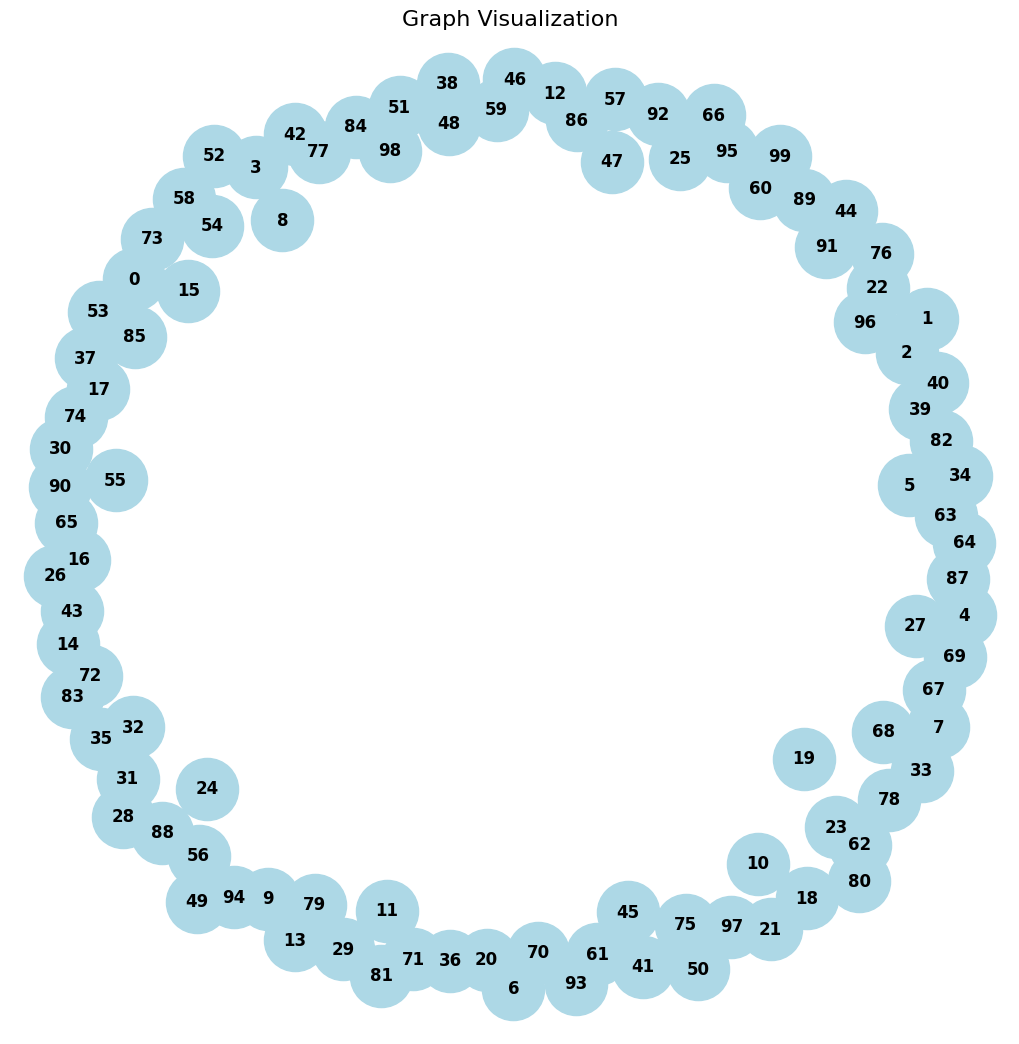

In [24]:
# GraphRAGクラスで作成したグラフ（graph_data）を可視化
def visualize_graph(graph):
    # ノードとエッジを描画
    pos = nx.spring_layout(graph)  # ノードの配置を決める
    plt.figure(figsize=(10, 10))   # 図のサイズ
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', font_size=12, node_size=2000, font_weight='bold', edge_color='gray')
    plt.title("Graph Visualization", fontsize=16)
    plt.show()

# GraphRAGのインスタンスが作成されていることを前提に可視化
visualize_graph(graph_data)